In [1]:
import helper_functions

import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import osmnx as ox
from shapely.geometry import Point, LineString, MultiLineString

gdf = gpd.read_file("data/sources/Hungary_2022_static_road_data.geojson")

geo_positions = {
    "Budapest": (47.497912, 19.040235),
    "Kecskemét": (46.906770, 19.691383),
    "Szeged": (46.253000, 20.141424),
    "Szolnok": (47.172424, 20.178190),
    "Debrecen": (47.531605, 21.627312),
    "Nyíregyháza": (47.955879, 21.716837),
    "Miskolc": (48.104385, 20.791731),
    "Dunaújváros": (46.961511, 18.940582),
    "Szekszárd": (46.348886, 18.706048),
    "Pécs": (46.072734, 18.232266),
    "Székesfehérvár": (47.186644, 18.422595),
    "Siófok": (46.911703, 18.040138),
    "Győr": (47.687453, 17.634782),
    "Sopron": (47.686567, 16.588856),
    "Szombathely": (47.130884, 16.621046),
    "div_point_Miskolc_Debrecen": (47.7, 20.2),
    "div_point_Debrecen_Nyíregyháza": (47.6, 20.8),
    "div_point_Sopron_Szombathely": (47.4, 17.2),
    "Veszprém": (47.093658, 17.911332)
}
cities = ['Budapest', 'Kecskemét', 'Szeged', 'Szolnok', 'Debrecen', 'Nyíregyháza', 'Miskolc', 'Dunaújváros',
          'Szekszárd', 'Pécs', 'Székesfehérvár', 'Siófok', 'Győr', 'Sopron', 'Szombathely', 'Veszprém']


<Axes: >

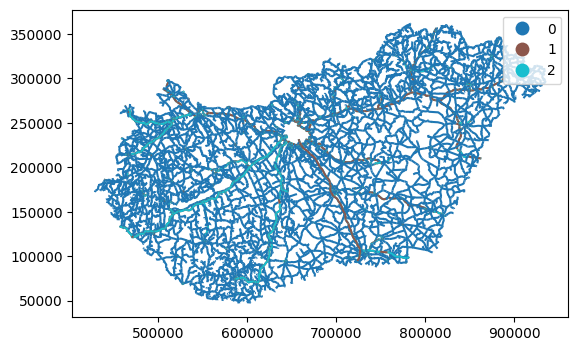

In [2]:
gdf.plot(column='pkod', legend=True)

In [3]:
gdf_simplified = gdf[gdf['pkod']!='2'].reset_index(drop=True)

## Intersections

The intersecting roads were looked up using this code (it can take ~30 minutes to run). I believe all of these should be "road above road" cases.

```python

In [4]:
from shapely.geometry import MultiLineString

intersecting_pairs = []
touching_pairs = []
geom_array = gdf_simplified['geometry'].to_numpy()
for i in range(len(gdf_simplified)):
    for j in range(i+1, len(gdf_simplified)):
        if geom_array[i].touches(geom_array[j]):
            touching_pairs.append((i, j))
        else:
            if geom_array[i].intersects(geom_array[j]):
                intersecting_pairs.append((i, j))

len(intersecting_pairs)

464

In [5]:
data = [{
    'kszam_1': gdf_simplified.loc[i, 'kszam'],
    'id_1': gdf_simplified.loc[i, 'id'],
    'anf_1': gdf_simplified.loc[i, 'anf'],
    'geometry_1': gdf_simplified.loc[i, 'geometry'],
    'kszam_2': gdf_simplified.loc[j, 'kszam'],
    'id_2': gdf_simplified.loc[j, 'id'],
    'anf_2': gdf_simplified.loc[j, 'anf'],
    'geometry_2': gdf_simplified.loc[j, 'geometry'],
} for i, j in intersecting_pairs]

gdf_simplified_intersecting_pairs = gpd.GeoDataFrame(data)
gdf_simplified_intersecting_pairs['geometry'] = gdf_simplified_intersecting_pairs.apply(
    lambda row: row['geometry_1'].union(row['geometry_2']), axis=1
)

C:\Users\hanic\AppData\Local\Temp\ipykernel_28012\2715084708.py:13: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  gdf_simplified_intersecting_pairs['geometry'] = gdf_simplified_intersecting_pairs.apply(


Save the intersections in a file, to load them later:

In [6]:
#Save geodataframe to file
gdf_simplified_intersecting_pairs['geometry_1'] = gdf_simplified_intersecting_pairs['geometry_1'].apply(lambda geom: geom.wkt)
gdf_simplified_intersecting_pairs['geometry_2'] = gdf_simplified_intersecting_pairs['geometry_2'].apply(lambda geom: geom.wkt)
gdf_simplified_intersecting_pairs.crs = gdf_simplified.crs

gdf_simplified_intersecting_pairs.to_file("data/Hungary_2022_intersecting_roadpairs.geojson", driver='GeoJSON')

## Network creation

Create a network graph from start and end points of roads:

In [7]:
nodes = {}
edges = []
edge_info = {}

geom_array = gdf_simplified['geometry'].to_numpy()
traffic_array = gdf_simplified['anf'].to_numpy()
counter_ID_array = gdf_simplified['asz'].to_numpy()
road_ID_array = gdf_simplified['kszam'].to_numpy()
id_array = gdf_simplified['id'].to_numpy()
for i in range(len(geom_array)):
    #Assuming MultiLineString - with only one element
    try:
        multiline = list(geom_array[i].geoms)
    except:
        print("Problem occured - likely geometry is not a MultiLineString, trying using a list with one element instead")
        multiline = [geom_array[i]]
    
    #Reusing existing points if they exist
    start_point = nodes.get(multiline[0].coords[0], Point(multiline[0].coords[0]))
    end_point = nodes.get(multiline[-1].coords[-1], Point(multiline[-1].coords[-1]))
    nodes[multiline[0].coords[0]] = start_point
    nodes[multiline[-1].coords[-1]] = end_point
    # Add a LineString to edges_2
    edge = (multiline[0].coords[0], multiline[-1].coords[-1])
    edges.append(edge)
    #Speed:
    #Could possibly use match - case
    if road_ID_array[i] in ['M3','M7','M8','M15','M31','M4','M5','M35','M1','M43','M6','M60','M30','M70']:
        roadtype = "highway"
        speed = 130
    elif "M" in road_ID_array[i]:
        roadtype = "expressway" #Also known as
        speed = 110
    elif len(road_ID_array[i]) in [2,3]:
        roadtype = "main road" #Could be primary or secondary
        speed = 90
    elif len(road_ID_array[i]) in [4,5]:
        roadtype = "local road" #Mellékút: összekötőút, bekötőút, etc.
        speed = 70 #If not nearby a settlement, the maximum speed is 90. Otherwise, 50.
    else:
        roadtype = "other"
        speed = 50
     
    edge_info[edge] = {
        'traffic': traffic_array[i],
        'counter_ID': counter_ID_array[i],
        'road_ID': road_ID_array[i],
        'road_type': roadtype,
        'speed': speed,
        'distance': multiline[0].length,
        'time (min)': (60/1000)*multiline[0].length / speed,
        'geometry': multiline[0],
        'id': id_array[i],  
    }

In [8]:
G = nx.Graph()

for coords, point in nodes.items():
    G.add_node(coords, x=point.x, y=point.y, location_name=None, ignore=True)

for edge in edges:
    start, end = edge
    G.add_edge(start, end, **edge_info[(start, end)])

G_copy = G.copy()

Let's check the nodes in the graph to see if they are really connected:

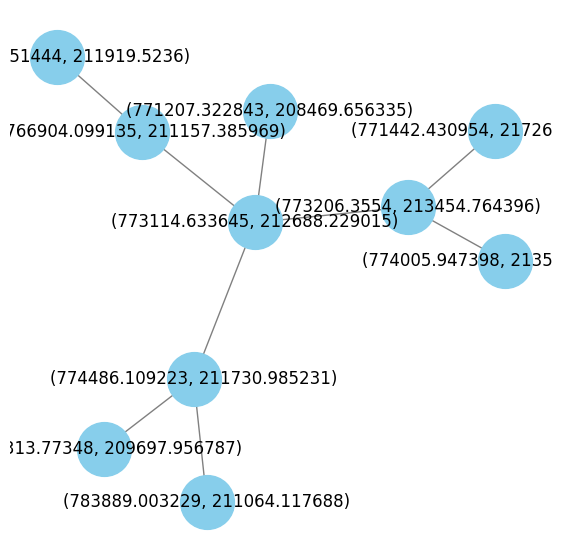

In [9]:
# Highest degree node
degs = dict(nx.degree(G))
max_node = max(degs, key=degs.get)
neighbors = list(G.neighbors(max_node))

# Add neighbors of neighbors
neighbors_of_neighbors = []
for neighbor in neighbors:
    neighbors_of_neighbors.extend(list(G.neighbors(neighbor)))

subgraph_nodes = [max_node] + neighbors + neighbors_of_neighbors
subgraph = G.subgraph(subgraph_nodes)

fig, ax = plt.subplots(figsize=(7,7))
nx.draw(subgraph, with_labels=True, node_color='skyblue', node_size=1500, edge_color='gray')
plt.show()

Good.

Let's plot components of the graph to see which ones are disconnected:

In [10]:
components = nx.connected_components(G)
print(len(list(components)))
print(np.max([len((list(nx.connected_components(G)))[i]) for i in range(len(list(nx.connected_components(G))))]))

118
11595


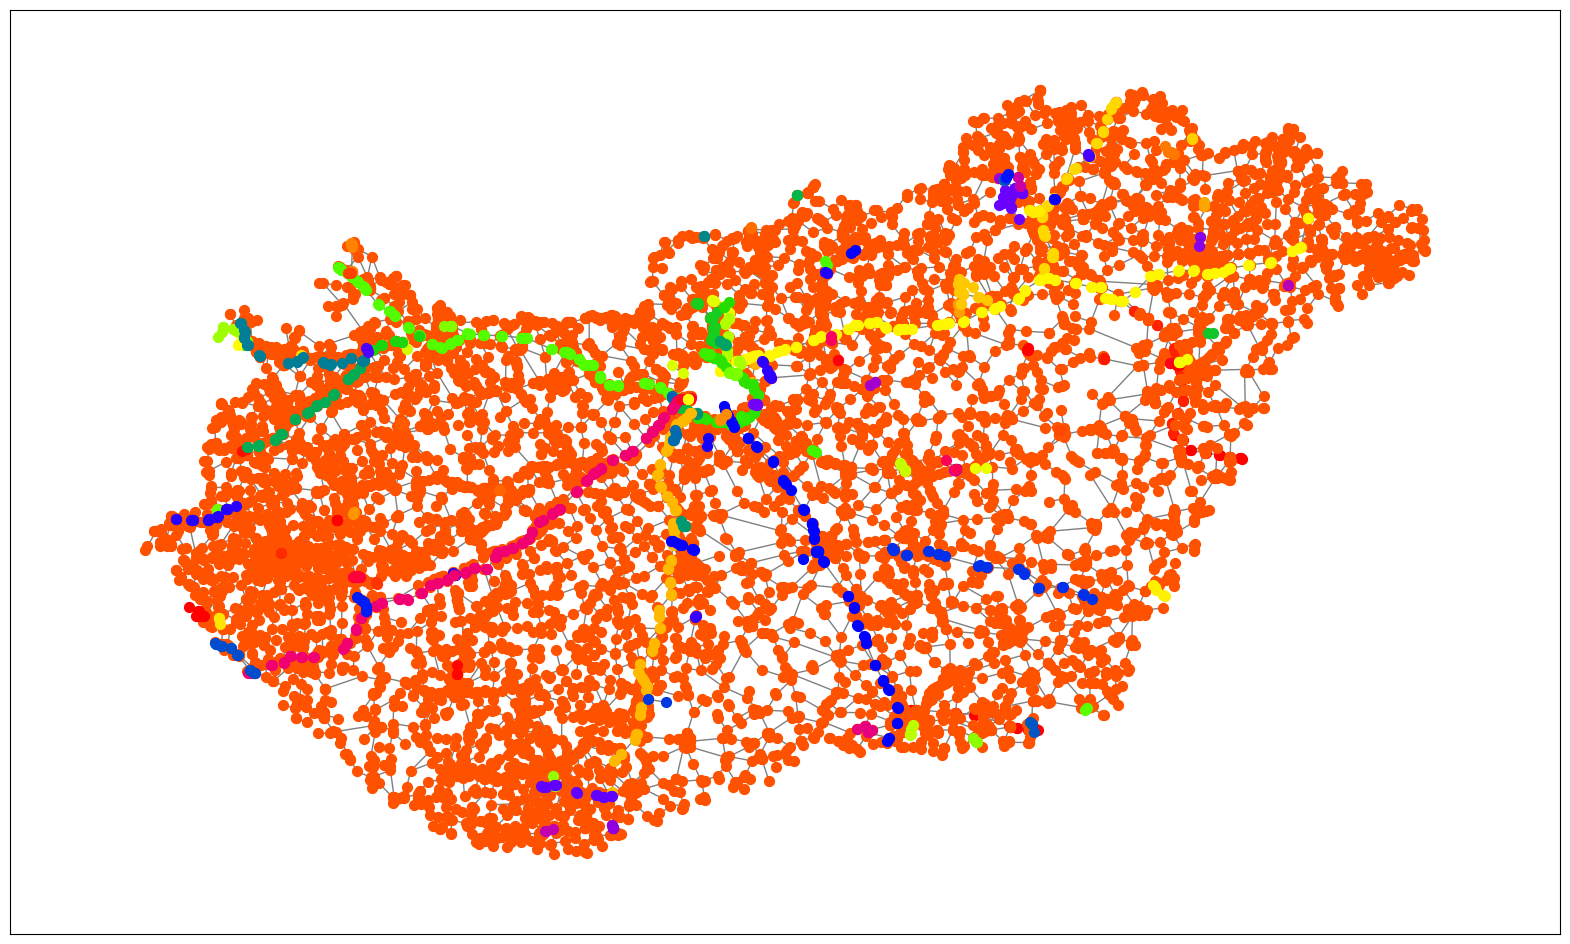

In [11]:
import matplotlib.cm
import matplotlib.colors
color_map = matplotlib.colormaps.get_cmap('prism')

plt.figure(figsize=(20, 12))
for i, component in enumerate((list(nx.connected_components(G)))):
    subgraph = G.subgraph(component)
    pos = {node: (attrs['x'], attrs['y']) for node, attrs in subgraph.nodes(data=True)}
    nx.draw_networkx(subgraph, pos=pos, node_color=[color_map(i)], with_labels=False, edge_color='gray', node_size=50,)
plt.show()

As you can see, many of the disconnected components are actually highways - these should be connected with access roads. Usually, some of those at least go above and "cross" (plane 2D geometrically) the highways. Connecting these will connect the highways to the main component.

## Intersection connections

Let's first add edges between intersecting roads:

In [12]:
def get_nodes_from_edge(edge, graph=None):
    #TODO Make it more general
    start_node = edge[0]
    end_node = edge[1]
    return start_node, end_node
    
def find_closest_nodes(node_list_1, node_list_2=None):
    min_distance = float('inf')
    closest_nodes = None
    
    if node_list_2 is None:
        #Search only within the same list
        for i in range(len(node_list_1)):
            for j in range(i+1, len(node_list_1)):
                distance = nodes[node_list_1[i]].distance(nodes[node_list_1[j]])
                if distance < min_distance:
                    min_distance = distance
                    closest_nodes = (node_list_1[i], node_list_1[j])
    else:
        for node1 in node_list_1:
            for node2 in node_list_2:
                distance = nodes[node1].distance(nodes[node2])
                if distance < min_distance: #Equal distances are not handled
                    min_distance = distance
                    closest_nodes = (node1, node2)
    return closest_nodes, min_distance

def connect_edges_if_needed(edge1, edge2, graph, **edge_attributes_kwargs):
    edge1_nodes = get_nodes_from_edge(edge1, graph)
    edge2_nodes = get_nodes_from_edge(edge2, graph)

    #If the edges share a node or are already connected, do nothing
    if set(edge1_nodes).intersection(edge2_nodes):
        return
    for node1 in edge1_nodes:
        for node2 in edge2_nodes:
            if (node1, node2) in graph.edges or (node2, node1) in graph.edges:
                return

    #Otherwise, connect the closest nodes
    closest_nodes, min_distance = find_closest_nodes(edge1_nodes, edge2_nodes)
    traffic_values = (graph.edges[edge1].get('traffic', 0), graph.edges[edge2].get('traffic', 0))
    speed = edge_attributes_kwargs.get('speed', 50)
    time = (60/1000)*min_distance / speed
    attrs_dict = {
        'traffic': edge_attributes_kwargs.get('traffic', min(traffic_values)),
        'counter_ID': edge_attributes_kwargs.get('counter_ID', None),
        'road_ID': edge_attributes_kwargs.get('road_ID', None),
        'road_type': edge_attributes_kwargs.get('road_type', "Artificially created"),
        'speed': speed,
        'distance': min_distance,
        'time (min)': time,
        'geometry': LineString([nodes[closest_nodes[0]], nodes[closest_nodes[1]]]),
        'id': None,
    }
    graph.add_edge(closest_nodes[0], closest_nodes[1], **attrs_dict)

In [13]:
for i,j in intersecting_pairs:
    edge1 = ((gdf_simplified.loc[i, 'geometry'].geoms[0]).coords[0], (gdf_simplified.loc[i, 'geometry'].geoms[0]).coords[-1])
    edge2 = ((gdf_simplified.loc[j, 'geometry'].geoms[0]).coords[0], (gdf_simplified.loc[j, 'geometry'].geoms[0]).coords[-1])
    connect_edges_if_needed(edge1, edge2, G)

In [14]:
geo_positions_gdf = helper_functions.create_location_gdf_with_crs(geo_positions, gdf.crs)

72
12514


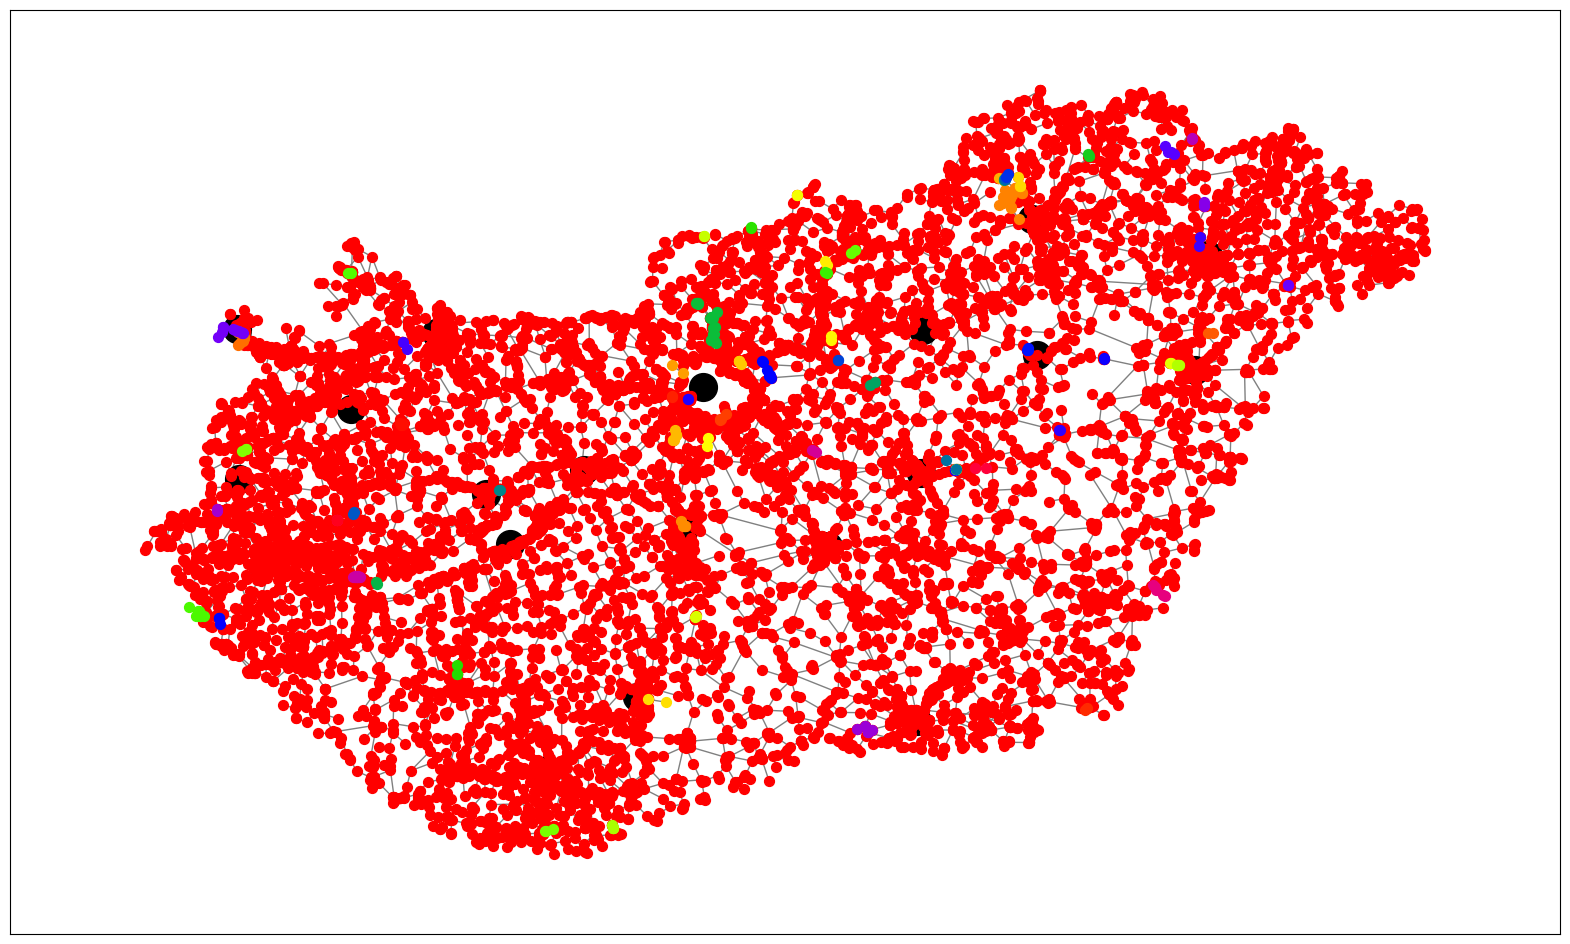

In [15]:
components = nx.connected_components(G)
print(len(list(components)))
print(np.max([len((list(nx.connected_components(G)))[i]) for i in range(len(list(nx.connected_components(G))))]))

plt.figure(figsize=(20, 12))
for i, component in enumerate((list(nx.connected_components(G)))):
    subgraph = G.subgraph(component)
    pos = {node: (attrs['x'], attrs['y']) for node, attrs in subgraph.nodes(data=True)}
    nx.draw_networkx(subgraph, pos=pos, node_color=[color_map(i)], with_labels=False, edge_color='gray', node_size=50,)

for geo in geo_positions_gdf['geometry']:
    plt.scatter(geo.coords[0][0] ,geo.coords[0][1], c='black', s=400)

We still have 72 disconnected components. We need to further connect nodes.

In [16]:
import pickle

with open("networks/Hungary_2022_road_network_intersected.pickle", "wb") as f:
    pickle.dump(G, f)

G_copy = pickle.load(open("networks/Hungary_2022_road_network_intersected.pickle", "rb"))

### Combine nodes nearby given locations into one

While this isn't directly to improve connectivity but for finding the nearest nodes given a location and combining them into one, this also reduces the disconnectivity a little bit.

In [17]:
def get_road_type_ranking(road_type):
    road_type_ranking = {"highway": 4, "expressway": 3, "main road": 2, "local road": 1}
    return road_type_ranking.get(road_type, 0)

def combine_two_nodes(G, node1, node2, location=None, name=None, return_node=False):
    G_ = G.copy()

    if node1 == node2:
        print("Two same nodes were selected, returning the original graph")
        return G_

    r = 0.01234567
    if location is None:
        #Average the location + bit of noise (we do not want to get an existing node)
        location = tuple(np.mean([node1, node2], axis=0) + r)
    else:
        #Check if it is in EPSG:23700 format, or common WSG84 (lat, lon) format
        #WSG84: EPSG:4326
        if ((location[0] <= 90) & (location[0]>=-90) & (location[1] <= 180) & (location[1]>=-180)):
            #Convert to EPSG:23700
            location = helper_functions.create_location_gdf_with_crs({"A": location}, gdf.crs).geometry[0].coords[0]

    if location == node1 or location == node2:
        print("Location is the same as one of the nodes, this is an issue - modifying it minimally")
        location = tuple(np.array([location[0],location[1]]) + r/10)
         
    ignore_ = False if name is not None else True
    #print(f"Creating new node at {location}")
    G_.add_node(location, x=location[0], y=location[1], location_name=name, ignore=ignore_)
    #Union of the two nodes
    neighbors = list(set(G_.neighbors(node1)) | set(G_.neighbors(node2)))
    for neighbor in neighbors:
        if neighbor in [node1, node2]:
            #One of the removed nodes
            continue

        #Combine the edge data
    
        if G_.has_edge(node1, neighbor) and G_.has_edge(node2, neighbor):
            attr_1 = G_.edges[node1, neighbor]
            attr_2 = G_.edges[node2, neighbor]
            highest_ranked_road = attr_1 if get_road_type_ranking(attr_1['road_type']) > get_road_type_ranking(attr_2['road_type']) else attr_2
            edge_data = {
                'traffic': attr_1.get('traffic', 0) + attr_2.get('traffic', 0),
                'counter_ID': None,
                'road_ID': None,
                'road_type': "Artificially created",
                'speed': highest_ranked_road['speed'],
                'distance': highest_ranked_road['distance'],
                'time (min)': highest_ranked_road['time (min)'],
                'geometry': attr_1['geometry'].union(attr_2['geometry']),
                'id': None,
            }
        elif G_.has_edge(node1, neighbor):
            edge_data = G_.edges[node1, neighbor]
        else:
            edge_data = G_.edges[node2, neighbor]

        G_.add_edge(location, neighbor, **edge_data)

    #print(f"Combined nodes {node1} and {node2} into {location}")
    G_.remove_node(node1)
    G_.remove_node(node2)

    if return_node:
        return G_, location
    return G_

from scipy.spatial import KDTree

def combine_all_nodes(G, nodes, location, name=None):
    G_ = G.copy()
    if not nodes:
        return G_
    # Combine nodes one by one
    
    r =  0.0000012 #This is to avoid removing the node in consecutive steps
    temporary_location = tuple(np.array([location[0],location[1]]) + r) 
    while len(nodes) > 2:
        node1, node2 = nodes[:2]
        G_, new_node = combine_two_nodes(G_, node1, node2, location=temporary_location, name=name, return_node=True)
        nodes = [new_node] + nodes[2:]
        temporary_location = tuple(np.array([temporary_location[0],temporary_location[1]]) + r)
    if len(nodes) == 2:
        G_ = combine_two_nodes(G_, nodes[0], nodes[1], location=location, name=name)
    return G_
    
def combine_nodes_in_radius(G, location_dict, radius = None, radius_dict=None):
    G_ = G.copy()
    if (radius is None) & (radius_dict is None):
        raise ValueError("Either radius or radius_dict must be specified")
    if radius_dict is None:
        radius_dict = {key: radius for key in location_dict.keys()}

    xs = np.array([x for x,y in list(location_dict.values())])
    ys = np.array([y for x,y in list(location_dict.values())])
    if (xs<=90).all() & (xs>=-90).all() & (ys<=180).all() & (ys>=-180).all():
        #Convert to EPSG:23700
        print("Converting the given location coordinates to EPSG:23700 (Hungarian format)")
        location_dict = {key: helper_functions.create_location_gdf_with_crs({key: val}, gdf.crs).geometry[0].coords[0] 
                         for key, val in location_dict.items()}

    node_positions = np.array([[attrs['x'], attrs['y']] for node, attrs in G_.nodes(data=True)])
    tree = KDTree(node_positions) #Quick lookup for nearest nodes

    node_list = list(G_.nodes())
    nodes_to_combine_dict = {}
    for location_name, coords in location_dict.items():
        radius = radius_dict.get(location_name, radius)
        indices = tree.query_ball_point(coords, radius)
        nodes_to_combine = [node_list[i] for i in indices]
        nodes_to_combine_dict[location_name] = nodes_to_combine

    for location_name, nodes_to_combine in nodes_to_combine_dict.items():
        #Check if any nodes are not in G_
        for node in nodes_to_combine:
            if node not in G_.nodes:
                print(f"Node {node} not in the graph anymore")
                nodes_to_combine.remove(node)
        G_ = combine_all_nodes(G_, nodes=nodes_to_combine, location=coords, name=location_name)
        #print(f"Combined nodes {nodes_to_combine} into {location_name}")

    return G_

def combine_nodes_in_radius_hotfix(G, location_dict, radius = None, radius_dict=None):
    G_t = G.copy()
    xs = np.array([x for x,y in list(location_dict.values())])
    ys = np.array([y for x,y in list(location_dict.values())])
    if (xs<=90).all() & (xs>=-90).all() & (ys<=180).all() & (ys>=-180).all():
        #Convert to EPSG:23700
        print("Converting the given location coordinates to EPSG:23700 (Hungarian format)")
        location_dict = {key: helper_functions.create_location_gdf_with_crs({key: val}, gdf.crs).geometry[0].coords[0] 
                         for key, val in location_dict.items()}

    temp_dict_list = [{key: val} for key, val in location_dict.items()]
    for i in range(len(temp_dict_list)):
        G_t = combine_nodes_in_radius(G_t, temp_dict_list[i], radius, radius_dict)

    return G_t

In [18]:
radius_dict = {
    "Budapest": 15000,
    "Kecskemét": 4000,
    "Szeged": 5000,
    "Szolnok": 3000,
    "Debrecen": 6000,
    "Nyíregyháza": 4000,
    "Miskolc": 4000,
    "Dunaújváros": 3000,
    "Szekszárd": 3000,
    "Pécs": 3000,
    "Székesfehérvár": 3000,
    "Siófok": 3000,
    "Győr": 4000,
    "Sopron": 3000,
    "Szombathely": 3000,
    "Veszprém": 3000,
    "div_point_Miskolc_Debrecen": 0,
    "div_point_Debrecen_Nyíregyháza": 0,
    "div_point_Sopron_Szombathely": 0,
}
G_t = combine_nodes_in_radius_hotfix(G, geo_positions, radius_dict=radius_dict)

Converting the given location coordinates to EPSG:23700 (Hungarian format)


63
11866


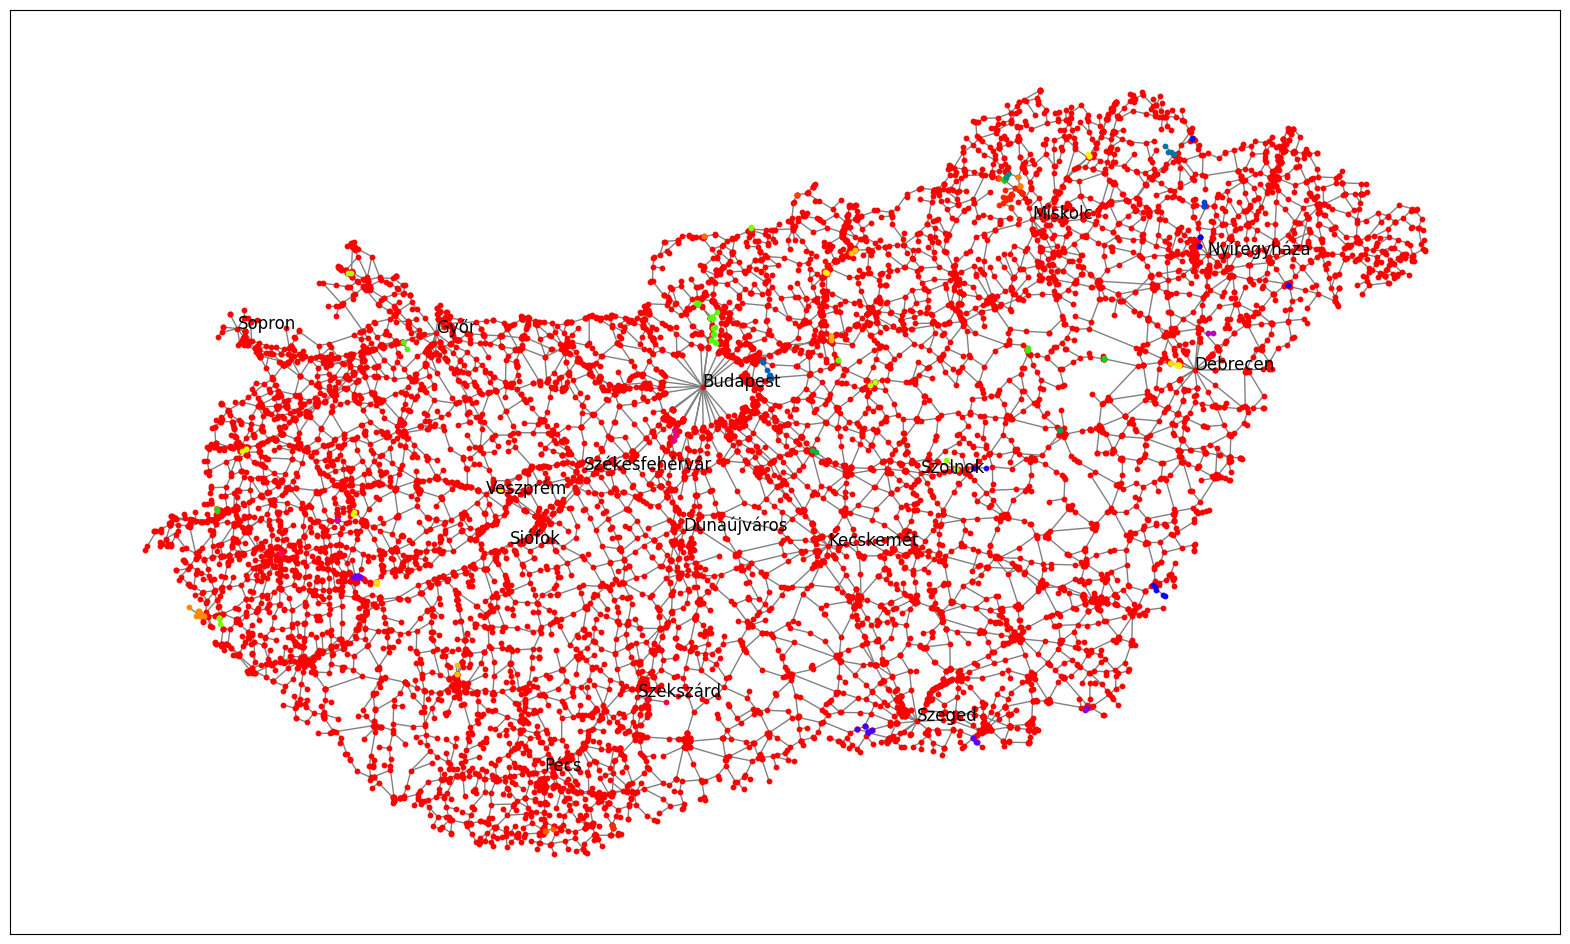

In [19]:
import matplotlib.cm
import matplotlib.colors
color_map = matplotlib.colormaps.get_cmap('prism')
components = nx.connected_components(G_t)
print(len(list(components)))
print(np.max([len((list(nx.connected_components(G_t)))[i]) for i in range(len(list(nx.connected_components(G_t))))]))

plt.figure(figsize=(20, 12))
for i, component in enumerate((list(nx.connected_components(G_t)))):
    subgraph = G_t.subgraph(component)
    pos = {node: (attrs['x'], attrs['y']) for node, attrs in subgraph.nodes(data=True)}
    nx.draw_networkx(subgraph, pos=pos, node_color=[color_map(i)], with_labels=False, edge_color='gray', node_size=10,)

#Plot the nodes with "name" attribute that have ignore=False
for node, attrs in G_t.nodes(data=True):
    if not attrs.get('ignore', True):
        #plt.scatter(attrs['x'], attrs['y'], c='black', s=300)
        plt.text(attrs['x'], attrs['y'], attrs['location_name'], fontsize=12)
plt.show()

Some isolated nodes were added to these cities - ideally, by including most settlements or towns, the number of disconnected components would reduce to very few - those may even be ignored. In this case with just 16 cities, we cannot throw away any remaining components, instead we connect the remaining components with nearest main component nodes.

In [20]:
with open("networks/Hungary_2022_road_network_combined_nodes.pickle", "wb") as f:
    pickle.dump(G_t, f)

## Connect isolated roads

Connect each component to the largest one with this algorithm:
- search for the closest node in the smaller component to the larger component (search through all nodes in both components)
- add an edge between the two nodes with edge attributes
- optionally: look for the furthest from the first node in the smaller component and connect it to the larger component as well
    (this would better lead to through-flow)

Isolated nodes if they exist are removed - although theoretically they should not exist, because we added nodes through edges.

In [21]:
import networkx as nx
import numpy as np

def components_process(G, double_connection=False):
    G_ = G.copy()
    components = sorted(nx.connected_components(G_), key=len, reverse=True)
    largest_component = components[0]

    #Remove isolated nodes
    isolated_nodes = [node for component in components for node in component if len(component) == 1]
    if len(isolated_nodes) > 0:
        print(f"Removing {len(isolated_nodes)} isolated nodes")
        G_.remove_nodes_from(isolated_nodes)

    #Connect each component to the largest one
    for component in components[1:]:
        component_subgraph = G_.subgraph(component)
        min_component_traffic = min([component_subgraph.edges[edge].get('traffic', 0) for edge in component_subgraph.edges])
                
        #Find closest node pair (go through all combinations)
        closest_node = min(
            ((node1, node2) for node1 in component for node2 in largest_component),
            key=lambda pair: np.linalg.norm(np.array([G_.nodes[pair[0]]['x'], G_.nodes[pair[0]]['y']])
                                            - np.array([G_.nodes[pair[1]]['x'], G_.nodes[pair[1]]['y']])))
        
        speed = 50
        distance = np.linalg.norm(np.array([G_.nodes[closest_node[0]]['x'], G_.nodes[closest_node[0]]['y']])
                                    - np.array([G_.nodes[closest_node[1]]['x'], G_.nodes[closest_node[1]]['y']]))
        time = (60/1000)*distance / speed
        edge_data = {
            'traffic': min_component_traffic,
            'counter_ID': None,
            'road_ID': None,
            'road_type': "Artificially created",
            'speed': speed,
            'distance': distance,
            'time (min)': time,
            'geometry': LineString([np.array([G_.nodes[closest_node[0]]['x'], G_.nodes[closest_node[0]]['y']]),
                                    np.array([G_.nodes[closest_node[1]]['x'], G_.nodes[closest_node[1]]['y']])]),
            'id': None
        }
        G_.add_edge(*closest_node, **edge_data)

        if double_connection:
            #Better for "flow": also connect another pair of nodes. The chosen node from the smaller component
                #is the furthest from the previously chosen node
            furthest_node = max(
                (node for node in component),
                key=lambda node: np.linalg.norm(np.array([G_.nodes[node]['x'], G_.nodes[node]['y']])
                                                - np.array([G_.nodes[closest_node[0]]['x'], G_.nodes[closest_node[0]]['y']])))
            #Closest node in the largest component
            closest_node_to_furthest = min(
                (node for node in largest_component),
                key=lambda node: np.linalg.norm(np.array([G_.nodes[node]['x'], G_.nodes[node]['y']])
                                                - np.array([G_.nodes[furthest_node]['x'], G_.nodes[furthest_node]['y']])))
            
            distance = np.linalg.norm(np.array([G_.nodes[furthest_node]['x'], G_.nodes[furthest_node]['y']])
                                    - np.array([G_.nodes[closest_node_to_furthest]['x'], G_.nodes[closest_node_to_furthest]['y']]))
            time = (60/1000)*distance / speed
            edge_data = {
                'traffic': min_component_traffic,
                'counter_ID': None,
                'road_ID': None,
                'road_type': "Artificially created",
                'speed': speed,
                'distance': distance,
                'time (min)': time,
                'geometry': LineString([np.array([G_.nodes[furthest_node]['x'], G_.nodes[furthest_node]['y']]),
                                        np.array([G_.nodes[closest_node_to_furthest]['x'], G_.nodes[closest_node_to_furthest]['y']])]),
                'id': None
            }
            G_.add_edge(furthest_node, closest_node_to_furthest, **edge_data)

    return G_

G_t_2 = components_process(G_t, double_connection=True)

1
12089


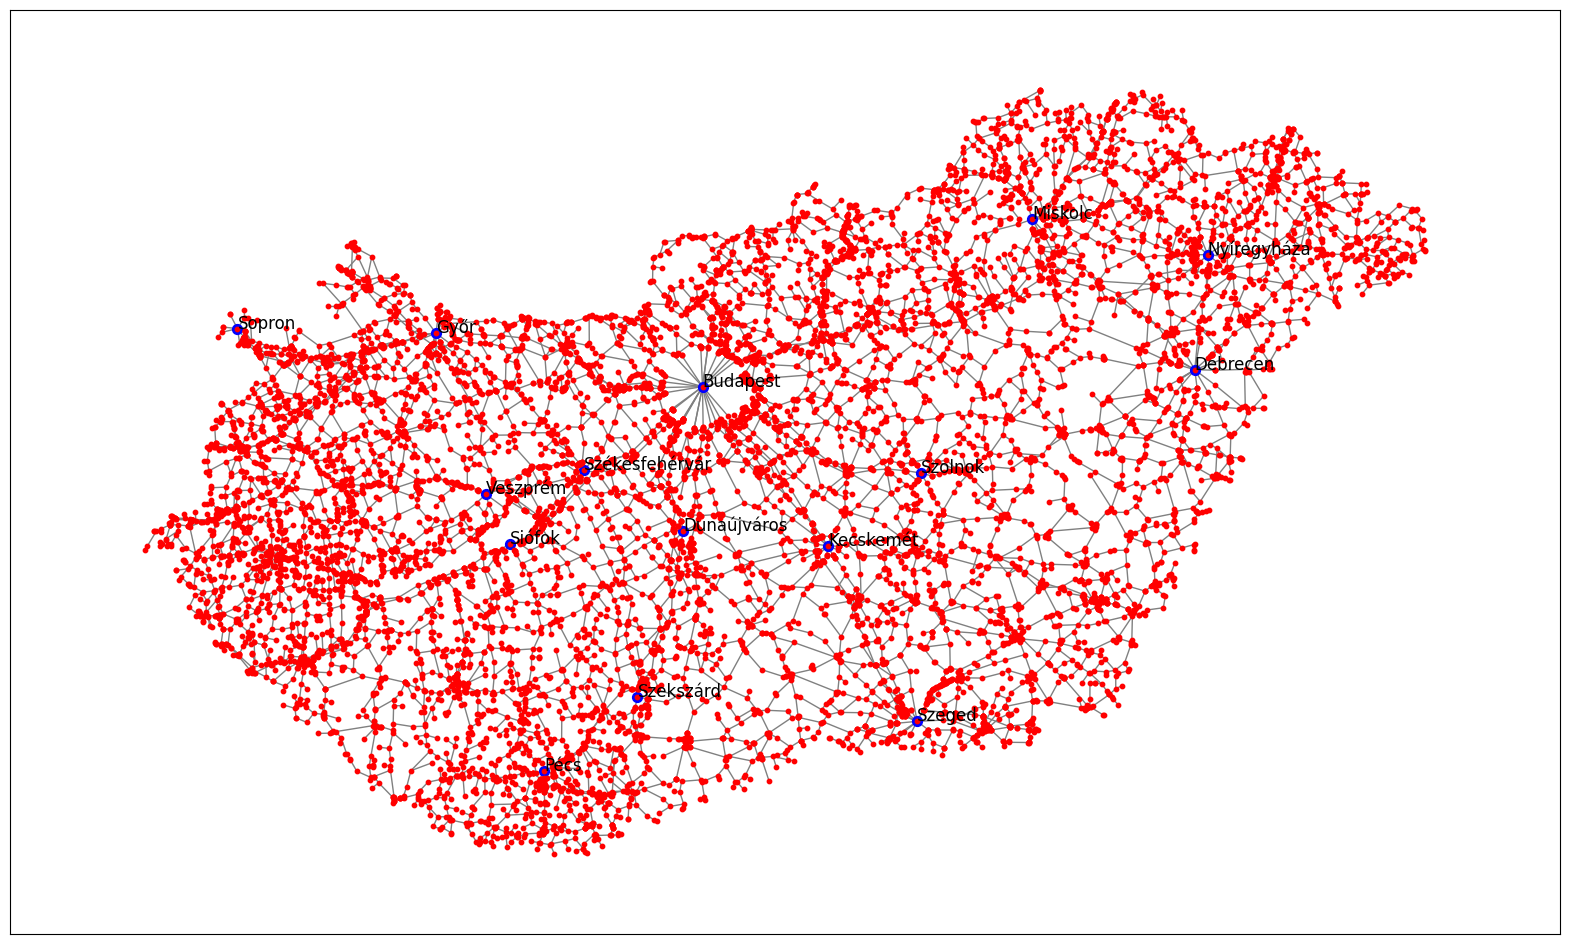

In [22]:
import matplotlib.cm
import matplotlib.colors
color_map = matplotlib.colormaps.get_cmap('prism')
components = nx.connected_components(G_t_2)
print(len(list(components)))
print(np.max([len((list(nx.connected_components(G_t_2)))[i]) for i in range(len(list(nx.connected_components(G_t_2))))]))

plt.figure(figsize=(20, 12))
for i, component in enumerate((list(nx.connected_components(G_t_2)))):
    subgraph = G_t_2.subgraph(component)
    pos = {node: (attrs['x'], attrs['y']) for node, attrs in subgraph.nodes(data=True)}
    nx.draw_networkx(subgraph, pos=pos, node_color=[color_map(i)], with_labels=False, edge_color='gray', node_size=10,)

#Plot the nodes with "name" attribute that have ignore=False
for node, attrs in G_t_2.nodes(data=True):
    if not attrs.get('ignore', True):
        plt.scatter(attrs['x'], attrs['y'], c='blue', s=50)
        plt.text(attrs['x'], attrs['y'], attrs['location_name'], fontsize=12)
plt.show()

In [23]:
#Add weights to the edges: equal to traffic

for edge in G_t_2.edges:
    G_t_2.edges[edge]['weight'] = G_t_2.edges[edge].get('traffic', 0)

In [24]:
with open("networks/Hungary_2022_road_network_connected.pickle", "wb") as f:
    pickle.dump(G_t_2, f)

## Distances

In [25]:
dist_array = np.array([])
node_1_array =np.array([]); node_2_array = np.array([])
nodes_array = np.array(G.nodes())
for i, component_1 in enumerate((list(nx.connected_components(G)))):
    if len(component_1) > 10000:
        continue
    for node_1 in component_1:
            distances = nodes_array-np.array(node_1)
            distances = np.linalg.norm(distances, axis=1)
            dist_array = np.append(dist_array, distances)
            node_1_array = np.append(node_1_array, np.array([node_1]*len(nodes_array)))
            node_2_array = np.append(node_2_array, nodes_array)

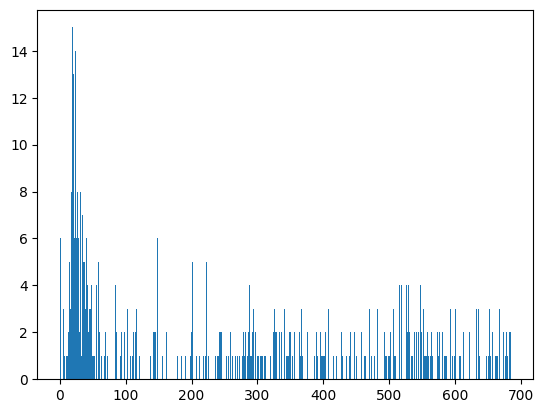

In [26]:
dist_array_chopped = (np.where(dist_array>0))
plt.hist(sorted(dist_array[dist_array_chopped])[:1000], bins=1000);

In [27]:
G=G_copy.copy()

In [28]:
def create_graph_from_gdf(gdf):
    nodes = {}
    edges = []
    #LUT to speed up the process
    #TODO
    for _, row in gdf.iterrows():
        if isinstance(row['geometry'], MultiLineString):
            multiline = list(row['geometry'].geoms)
        else:
            multiline = [row['geometry']]
        for linestring in multiline:
            start_point = nodes.get(linestring.coords[0], Point(linestring.coords[0]))
            end_point = nodes.get(linestring.coords[-1], Point(linestring.coords[-1]))
            nodes[linestring.coords[0]] = start_point
            nodes[linestring.coords[-1]] = end_point
            edges.append((start_point, end_point))

    G = nx.Graph()
    for coords, point in nodes.items():
        G.add_node(coords, x=point.x, y=point.y)
    G.add_edges_from(edges)

    return G